# iLykei Lecture Series 

# Machine Learning   

# Decision Trees

# Workshop 1: Recursive Binary Splitting

## Y.Balasanov, L.Nazarov, V. Lavrent'ev, M.Tselishchev &copy; iLykei 2017-24

Import necessary packages.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from io import StringIO
import pydotplus
from IPython.display import Image


We will also use function *plot_tree* for visualisation.

In [2]:
def plot_tree(estimator,feature_names):
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data,feature_names=feature_names,
                   rounded=True,filled=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return Image(graph.create_png())

# Example on binary splitting

In [3]:
tree_data = pd.read_csv("binary_splitting_data.csv")
tree_data

,y,x1,x2
0,0.162298,0.926459,0.366176
1,9.033972,1.822821,-1.327041
2,-10.962341,-1.610567,2.412592
3,-0.940886,-0.285110,0.063815
4,-4.902579,-0.342073,1.545515


## Preparing functions for sums of squares   

Prepare functions for calculating sum of squares of one split candidate `oneSplit(Data,Variable,Split)`, and for calculating sums of squares and split levels for all split candidates: `selectSplit(Data)`.     

First function is `oneSplit(myData,myVariable,mySplit)`, where     

* `myData` is the matrix of data including both response and predictors;    
* `myVariable` is variable number among predictors, which splits the set;    
* `splitLevel` is the level at which the variable is split.

The steps of this function are:    

1. Create an index `idx` of logical values separating rows of `myData` belonging to different regions after the split; `< mySplit` corresponds `idx==TRUE`;     
2. Create subsets according to the `idx`;    
3. Calculate mean values of response `y` for both subsets;    
4. Calculate sums of squares of `y-mean(y)` for each subset and add them together; this is the value returned by function `oneSplit(myData,myVariable,mySplit)`     


Second function is `selectSplit(myData)` which calls function `oneSplit(myData,myVariable,mySplit)` to decide which variable and at which level should make the next split.     

The steps of the function are:      

1. CReate variables `x1` and `x2` as sorted original predictor variables from small to large;    
2. Create variable `splits` as data frame of two variables of midpoints of  `x1` and `x2`; this variable is a data frame with variables names `x1` and `x2`;     
3. Create variables `splits1.SS`, `splits2.SS` each of which is vector of sums of squares of all splits by the corresponding variable; this is done by function `oneSplit(myData,myVariable,mySplit)`  
4. Create output in the form of list of 2 data frames:     

* SS=data.frame(`splits1.SS`,`splits2.SS`)    
* splits     

<span style="color:red">(Try to do yourself)</span>    

*******    
*******    
*******    
*******    
*******

In [4]:
def oneSplit(myData,myVariable,mySplit):
    # myData: numpy ndarray of data including response in column 0
    # myVariable: number of variable that needs split 1:ncol(myData)
    # mySplit: split level
    # convert to numpy.ndarray
    if isinstance(myData, pd.core.frame.DataFrame): myData = myData.values
    idx = myData[:,myVariable]<mySplit # separate variable by mySplit 
    mean1 = np.mean(myData[idx,0])
    mean2 = np.mean(myData[~idx,0])
    return np.sum((myData[idx,0]-mean1)**2) + np.sum((myData[~idx,0]-mean2)**2)

def selectSplit(myData):
    # myData: numpy ndarray of data including response in column 0
    # sort variables
    splits = pd.DataFrame({'x1':sorted(myData.x1),'x2':sorted(myData.x2)})
    # rolling mean of each 2 elements in column
    splits = splits.rolling(2).mean().dropna().reset_index(drop=True)
    
    # calculate sums of squares of all splits
    splits1_SS = [oneSplit(myData,1,splits.x1[z]) for z in np.arange(len(splits))]
    splits2_SS = [oneSplit(myData,2,splits.x2[z]) for z in np.arange(len(splits))]
    # out: sums of squares and splits
    return {'SS':pd.DataFrame({'splits1_SS':splits1_SS,'splits2_SS':splits2_SS}),
                              'splits':splits}


*****     
*****     

## Find `node1` - the first split variable and split level.

<span style="color:red">(Try to do yourself)</span>

*******    
*******    
*******    
*******    
*******

In [5]:
# splits for node 1
node1 = selectSplit(tree_data)
for k,v in node1.items(): print(k,'\n',v)
    
# which variable needs split? compare minimum SS for each variable
splitVar = 2 if min(node1["SS"].splits1_SS)>=min(node1["SS"].splits2_SS) else 1
print('splitVar =', splitVar)

SS 
    splits1_SS  splits2_SS
0  103.749224   75.868220
1   78.167499  111.792670
2   90.301727   78.167499
3   75.868220  103.749224
splits 
          x1        x2
0 -0.976320 -0.631613
1 -0.313591  0.214996
2  0.320675  0.955845
3  1.374640  1.979053
splitVar = 2


In [6]:
# where is to split? row number corresponding to smallest SS
splitNum = np.argmin(node1["SS"].splits1_SS) if splitVar==1 else np.argmin(
                                                node1["SS"].splits2_SS)  
print('splitNum =', splitNum)

# what is the split level? row splitNum in column splitVar
splitLevel_1 = node1["splits"].iloc[splitNum,splitVar-1]
print('splitLevel_1 =', splitLevel_1)

splitNum = 0
splitLevel_1 = -0.6316127504975932


*******    
*******    
*******    

## Create 2 regions $R_1$ and $R_2$ breaking the initial sample.    

What are the regions?

In [7]:
mask = tree_data.iloc[:,splitVar]>=splitLevel_1
Reg1 = tree_data[mask]
print(Reg1)
Reg2 = tree_data[~mask]
print(Reg2)

           y        x1        x2
0   0.162298  0.926459  0.366176
2 -10.962341 -1.610567  2.412592
3  -0.940886 -0.285110  0.063815
4  -4.902579 -0.342073  1.545515
          y        x1        x2
1  9.033972  1.822821 -1.327041


In [8]:
print(mask)
tree_data.iloc[:,splitVar]

0     True
1    False
2     True
3     True
4     True
Name: x2, dtype: bool


0    0.366176
1   -1.327041
2    2.412592
3    0.063815
4    1.545515
Name: x2, dtype: float64

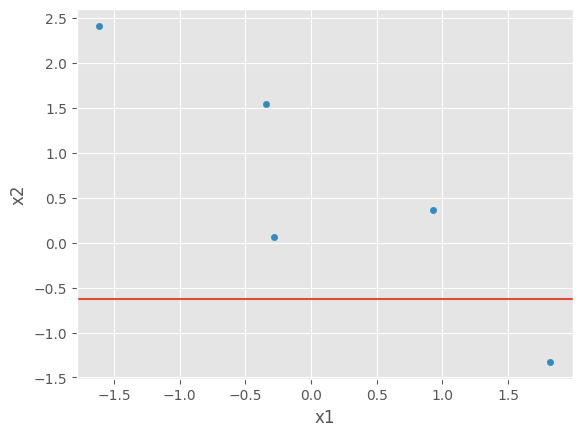

In [9]:
ax = tree_data.drop('y',axis=1).plot(x='x1',y='x2',kind='scatter')
if splitVar==1: plt.axvline(x=splitLevel_1)
else: plt.axhline(y=splitLevel_1)

## Which of the regions $R_1$, $R_2$ needs a split?

In [10]:
node2 = selectSplit(Reg2)
print(node2)

{'SS': Empty DataFrame
Columns: [splits1_SS, splits2_SS]
Index: [], 'splits': Empty DataFrame
Columns: [x1, x2]
Index: []}


Looks like leaf.

In [11]:
node2 = selectSplit(Reg1)
print(node2)

{'SS':    splits1_SS  splits2_SS
0   14.188337   62.043766
1   18.968864   18.968864
2   50.948426   14.188337, 'splits':          x1        x2
0 -0.976320  0.214996
1 -0.313591  0.955845
2  0.320675  1.979053}


This needs further split.   

## Split $R_1$ by creating regions $R_3$ and $R_4$ 

<span style="color:red">(Try to do yourself)</span>

*******    
*******    
*******    
*******    
*******

In [12]:
splitVar = 2 if min(node2["SS"].splits1_SS)>min(node2["SS"].splits2_SS) else 1
print('splitVar =', splitVar)

splitVar = 1


*******    
*******    
*******    

## What are the split variables and split levels?    

<span style="color:red">(Try to do yourself)</span>

*******    
*******    
*******    
*******    
*******

In [13]:
splitNum = np.argmin(node2["SS"].splits1_SS) if splitVar==1 else np.argmin(
                                                node2["SS"].splits2_SS)  
print('splitNum =', splitNum)

splitLevel_2 = node2["splits"].iloc[splitNum,splitVar-1]
print('splitLevel_2 =', splitLevel_2)

splitNum = 0
splitLevel_2 = -0.9763199640224745


*******    
*******    
*******    

## Create the next breakup.   

<span style="color:red">(Try to do yourself)</span>

*******    
*******    
*******    
*******    
*******

In [14]:
mask = Reg1.iloc[:,splitVar]>=splitLevel_2
Reg3 = Reg1[mask]
print(Reg3)
Reg4 = Reg1[~mask]
print(Reg4)

          y        x1        x2
0  0.162298  0.926459  0.366176
3 -0.940886 -0.285110  0.063815
4 -4.902579 -0.342073  1.545515
           y        x1        x2
2 -10.962341 -1.610567  2.412592


*******    
*******    
*******

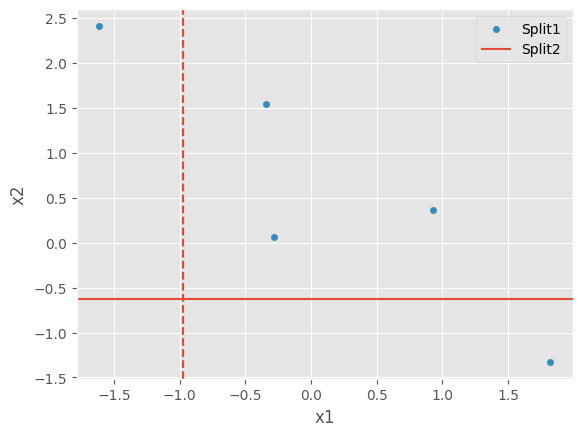

In [15]:
# using ax we continue editing the above plot
if splitVar==1:
    ax.axvline(x=splitLevel_2,linestyle='--')
else:
    ax.axhline(y=splitLevel_2,linestyle='--')
ax.legend(['Split1','Split2'],bbox_to_anchor=(1, 1))
ax.get_figure()

## Which region needs a split?    

<span style="color:red">(Try to do yourself)</span>

*******    
*******    
*******    
*******    
*******

In [16]:
node3 = selectSplit(Reg4)
print(node3)

{'SS': Empty DataFrame
Columns: [splits1_SS, splits2_SS]
Index: [], 'splits': Empty DataFrame
Columns: [x1, x2]
Index: []}


*******    
*******    
*******    

Found a leaf in $R_4$.

In [17]:
node3 = selectSplit(Reg3)
for k,v in node3.items(): print(k,'\n',v)

SS 
    splits1_SS  splits2_SS
0    0.608508   12.826492
1    7.847506    0.608508
splits 
          x1        x2
0 -0.313591  0.214996
1  0.320675  0.955845


This needs further split


## Select next split variable for $R_3$.    

<span style="color:red">(Try to do yourself)</span>

*******    
*******    
*******    
*******    
*******

In [18]:
splitVar = 2 if min(node3["SS"].splits1_SS)>min(node3["SS"].splits2_SS) else 1
print('splitVar =', splitVar)

splitVar = 1


*******    
*******    
*******

In [19]:
splitNum = np.argmin(node3["SS"].splits1_SS) if splitVar==1 else np.argmin(
                                                node3["SS"].splits2_SS)  
print('splitNum =', splitNum)

splitLevel_3 = node3["splits"].iloc[splitNum,splitVar-1]
print('splitLevel_3 =', splitLevel_3)

splitNum = 0
splitLevel_3 = -0.31359139097064603


## Create regions $R_5$ and $R_6$.    

<span style="color:red">(Try to do yourself)</span>

*******    
*******    
*******    
*******    
*******

In [20]:
mask = Reg3.iloc[:,splitVar]>=splitLevel_3
Reg5 = Reg3[mask]
print(Reg5)
Reg6 = Reg3[~mask]
print(Reg6)

          y        x1        x2
0  0.162298  0.926459  0.366176
3 -0.940886 -0.285110  0.063815
          y        x1        x2
4 -4.902579 -0.342073  1.545515


*******    
*******    
*******

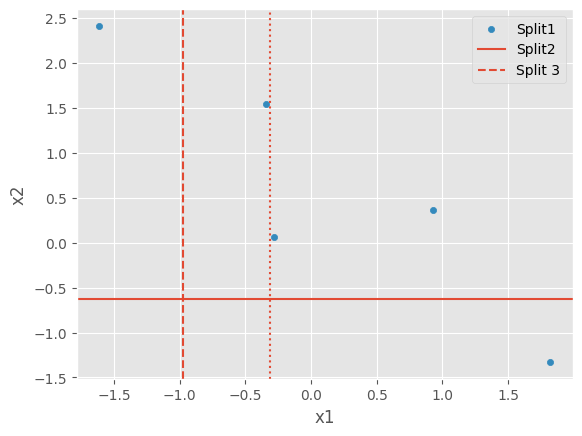

In [21]:
# using ax we continue editing the above plot
if splitVar==1:
    ax.axvline(x=splitLevel_3,linestyle=':')
else:
    ax.axhline(y=splitLevel_3,linestyle=':')
ax.legend(['Split1','Split2','Split 3'],bbox_to_anchor=(1, 1))
ax.get_figure()

## Find mean values of all regions.    

Since all regions, but $R_5$ contain only one observation need to average only $R_5$.

In [22]:
[np.mean(r.y) for r in [Reg1,Reg2,Reg3,Reg4,Reg5,Reg6]]

[np.float64(-4.1608770553392915),
 np.float64(9.03397249583563),
 np.float64(-1.893722409511722),
 np.float64(-10.962340992822),
 np.float64(-0.389293988930543),
 np.float64(-4.90257925067408)]

## Summary    

1. Initial split is at $X_1$ at level *splitLevel_1*.     
2. Second split is at $X_1$ at level *splitLevel_2*.   
3. Third split is at $X_1$ at level *splitLevel_3*.    

## Check the splits against fitted tree.

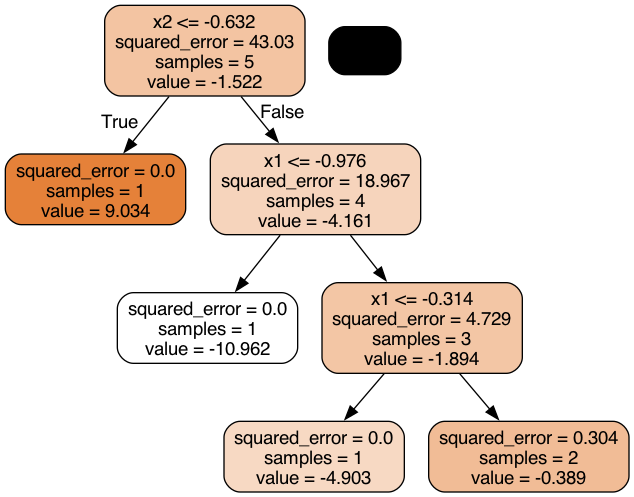

In [23]:
built_tree = DecisionTreeRegressor(random_state=0,max_leaf_nodes=4)
built_tree.fit(tree_data.drop('y',axis=1),tree_data.y)
plot_tree(built_tree,['x1','x2'])

Compare the 'value' in each leaf with regions' mean values calculated above.